In [1]:
# import libraries

import numpy as np
import mdtraj as mdt
import MDAnalysis as mda
import matplotlib.pyplot as plt

from contact_map import ContactMap, ContactFrequency, ContactDifference, OverrideTopologyContactDifference


In [6]:
# point to filepaths
trjpath = "/Users/asakalish/Desktop/Classes/BP 219/trajectories/"

ptopapo = f"{trjpath}DESRES-Trajectory_sarscov2-10875753-no-water-zinc-glueCA/sarscov2-10875753-no-water-zinc-glueCA/apo_top.pdb"
ptopholo = f"{trjpath}DESRES-Trajectory_sarscov2-10875754-no-water-zinc-glueCA/sarscov2-10875754-no-water-zinc-glueCA/holo_top.pdb"

ptrjapo  = f"{trjpath}DESRES-Trajectory_sarscov2-10875753-no-water-zinc-glueCA/sarscov2-10875753-no-water-zinc-glueCA/sarscov2-10875753-no-water-zinc-glueCA-"
ptrjholo = f"{trjpath}DESRES-Trajectory_sarscov2-10875754-no-water-zinc-glueCA/sarscov2-10875754-no-water-zinc-glueCA/sarscov2-10875754-no-water-zinc-glueCA-"

In [8]:
# load all 9 trajectories for each system into a list and then join them

trjsapo = []
trjshol = []

for i in range(0,9):
    trjsapo.append(mdt.load_dcd(ptrjapo + str(i).zfill(4) + ".dcd", top = ptopapo))
    trjshol.append(mdt.load_dcd(ptrjholo + str(i).zfill(4) + ".dcd", top = ptopholo))
    
trjapo = mdt.join(trjsapo)
trjholo = mdt.join(trjshol)

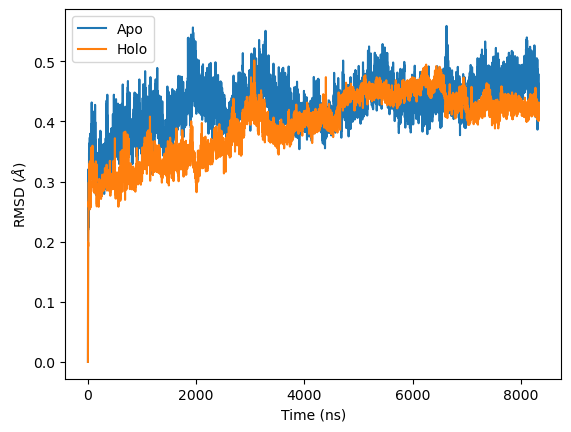

In [143]:
# compute rmsd of each trajectory and plot
protein_sel1 = trjapo.topology.select('protein')
protein_traj1 = trjapo.atom_slice(protein_sel1)
rmsd1 = mdt.rmsd(protein_traj1, protein_traj1, frame=0)

protein_sel2 = trjholo.topology.select('protein')
protein_traj2 = trjholo.atom_slice(protein_sel2)
rmsd2 = mdt.rmsd(protein_traj2, protein_traj2,  frame=0)

plt.plot(rmsd1);
plt.plot(rmsd2);

plt.xlabel('Time (ns)');
plt.ylabel('RMSD ($\AA$)');

plt.legend(['Apo','Holo'])


In [17]:
#calculate RMSF of each atom
# reference None defaults to comparison to (time) average
rmsf_apo = mdt.rmsf(trjapo, reference = None)
rmsf_holo = mdt.rmsf(trjholo, reference = None)

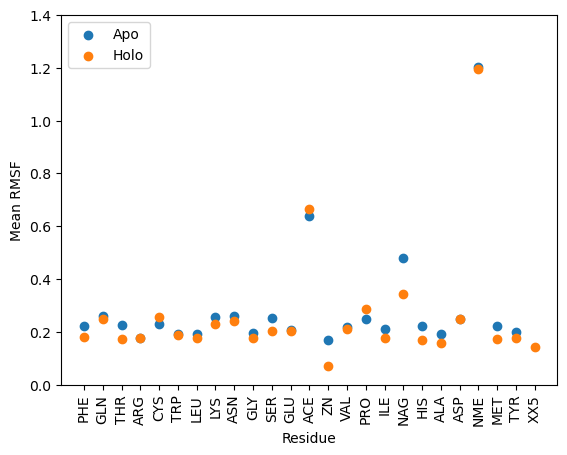

In [144]:
# try plotting mean rmsf for each amino acid

# get name of each residue, put in list
# filter out 
names = []
namesh = []

for res in trjapo.top.residues:
    names.append(res.name)
    
for res in trjholo.top.residues:
    namesh.append(res.name)
# remove repeat names and assign to names_f
names_f = list(set(names))
names_fh = list(set(namesh))
# init an array for rmsf by amino acid
rmsf_aa = []
rmsf_haa = []

for res in names_f:
    n = 'resname ' + res
    rmsf_aa.append(rmsf_apo[trjapo.top.select(n)])
    
for res in names_fh:
    n = 'resname ' + res
    rmsf_haa.append(rmsf_holo[trjholo.top.select(n)])

means = []
meansh= []
for i in range(0,len(rmsf_aa)):
    means.append(np.mean(rmsf_aa[i]))
    
for i in range(0,len(rmsf_haa)):
    meansh.append(np.mean(rmsf_haa[i]))
    
plt.scatter(names_f, means);
plt.scatter(names_fh, meansh)
plt.xticks(rotation = 90);

plt.ylim([0, 1.4])
plt.xlabel('Residue')
plt.ylabel('Mean RMSF')
plt.legend(['Apo','Holo'])


In [40]:
# method to get target residues
def get_nearby_residues(holo_xtal, ligand_resn, dist_cutoff):

    #handle bricks
    if ligand_resn == "None":
        print("no valid ligands found")
        return []

    #handle everything else
    if type(ligand_resn) == str: #select single ligands
        ligand_select_str = f"resname '{ligand_resn}'"

    elif len(ligand_resn)>1:     #select multiple ligands
        #assemble query for all ligands listed
        molecule_queries = []
        for lname in ligand_resn:
            molecule_queries.append(f"resname '{lname}'")
        ligand_select_str = " or ".join(molecule_queries)

    else:                        #use hardcoded query
        ligand_select_str = ligand_resn[0]

    #get indices of ligand and protein atoms
    ligand_ai = holo_xtal.top.select(f"({ligand_select_str}) and not element H")
    protein_ai = holo_xtal.top.select("protein and not element H")

    #get indices of ligand-coordinating protein atoms; index 0 indicates the 0th trajectory frame
    lining_ai = mdt.compute_neighbors(holo_xtal, dist_cutoff, ligand_ai, haystack_indices=protein_ai, periodic = False)[0]

    #get residue indices and numbers for the holo structure
    lining_resids = np.unique([holo_xtal.top.atom(i).residue.index for i in lining_ai])    #0-indices of the lining residues in the mdtraj structure
    lining_resseqs = np.unique([holo_xtal.top.atom(i).residue.resSeq for i in lining_ai])  #rcsb pdb residue numbers of the lining residues
    
    #print([f"resid {i}" for i in lining_resids])
    lining_ai_resi = np.unique(holo_xtal.top.select(" or ".join([f"resid {i}" for i in lining_resids])))
    
    lining_ai_byresi = [holo_xtal.top.select(f"resid {i}") for i in lining_resids]
    lining_names_byresi = [str(holo_xtal.top.atom(holo_xtal.top.select(f"resid {i}")[0]).residue) for i in lining_resids]

    return [lining_ai, lining_resids, lining_resseqs, lining_ai_resi, lining_ai_byresi, lining_names_byresi]

In [41]:
# get indices of residues lining binding pocket
dist_cutoff = 0.5 #nanometers
ligand_resn = "XX5"
topholo = mdt.load(ptopholo)

lining_inds = get_nearby_residues(topholo, ligand_resn, dist_cutoff)

In [43]:
# print indices of residues lining binding pocket
lining_inds[1]

array([126, 127, 131, 253, 255, 256, 327, 328, 329, 342, 345, 350, 353,
       356, 357, 360, 384, 486, 487, 492, 496, 497, 500])

In [23]:
# compute pairwise contact frequencies for apo trajectory
apo_contacts = ContactFrequency(trjapo)

In [24]:
# compute pairwise contact frequencies for holo trajectory
holo_contacts = ContactFrequency(trjholo)

In [25]:
# override necessary for contact maps from different pdbs
diff = OverrideTopologyContactDifference(apo_contacts, holo_contacts, trjapo.top)

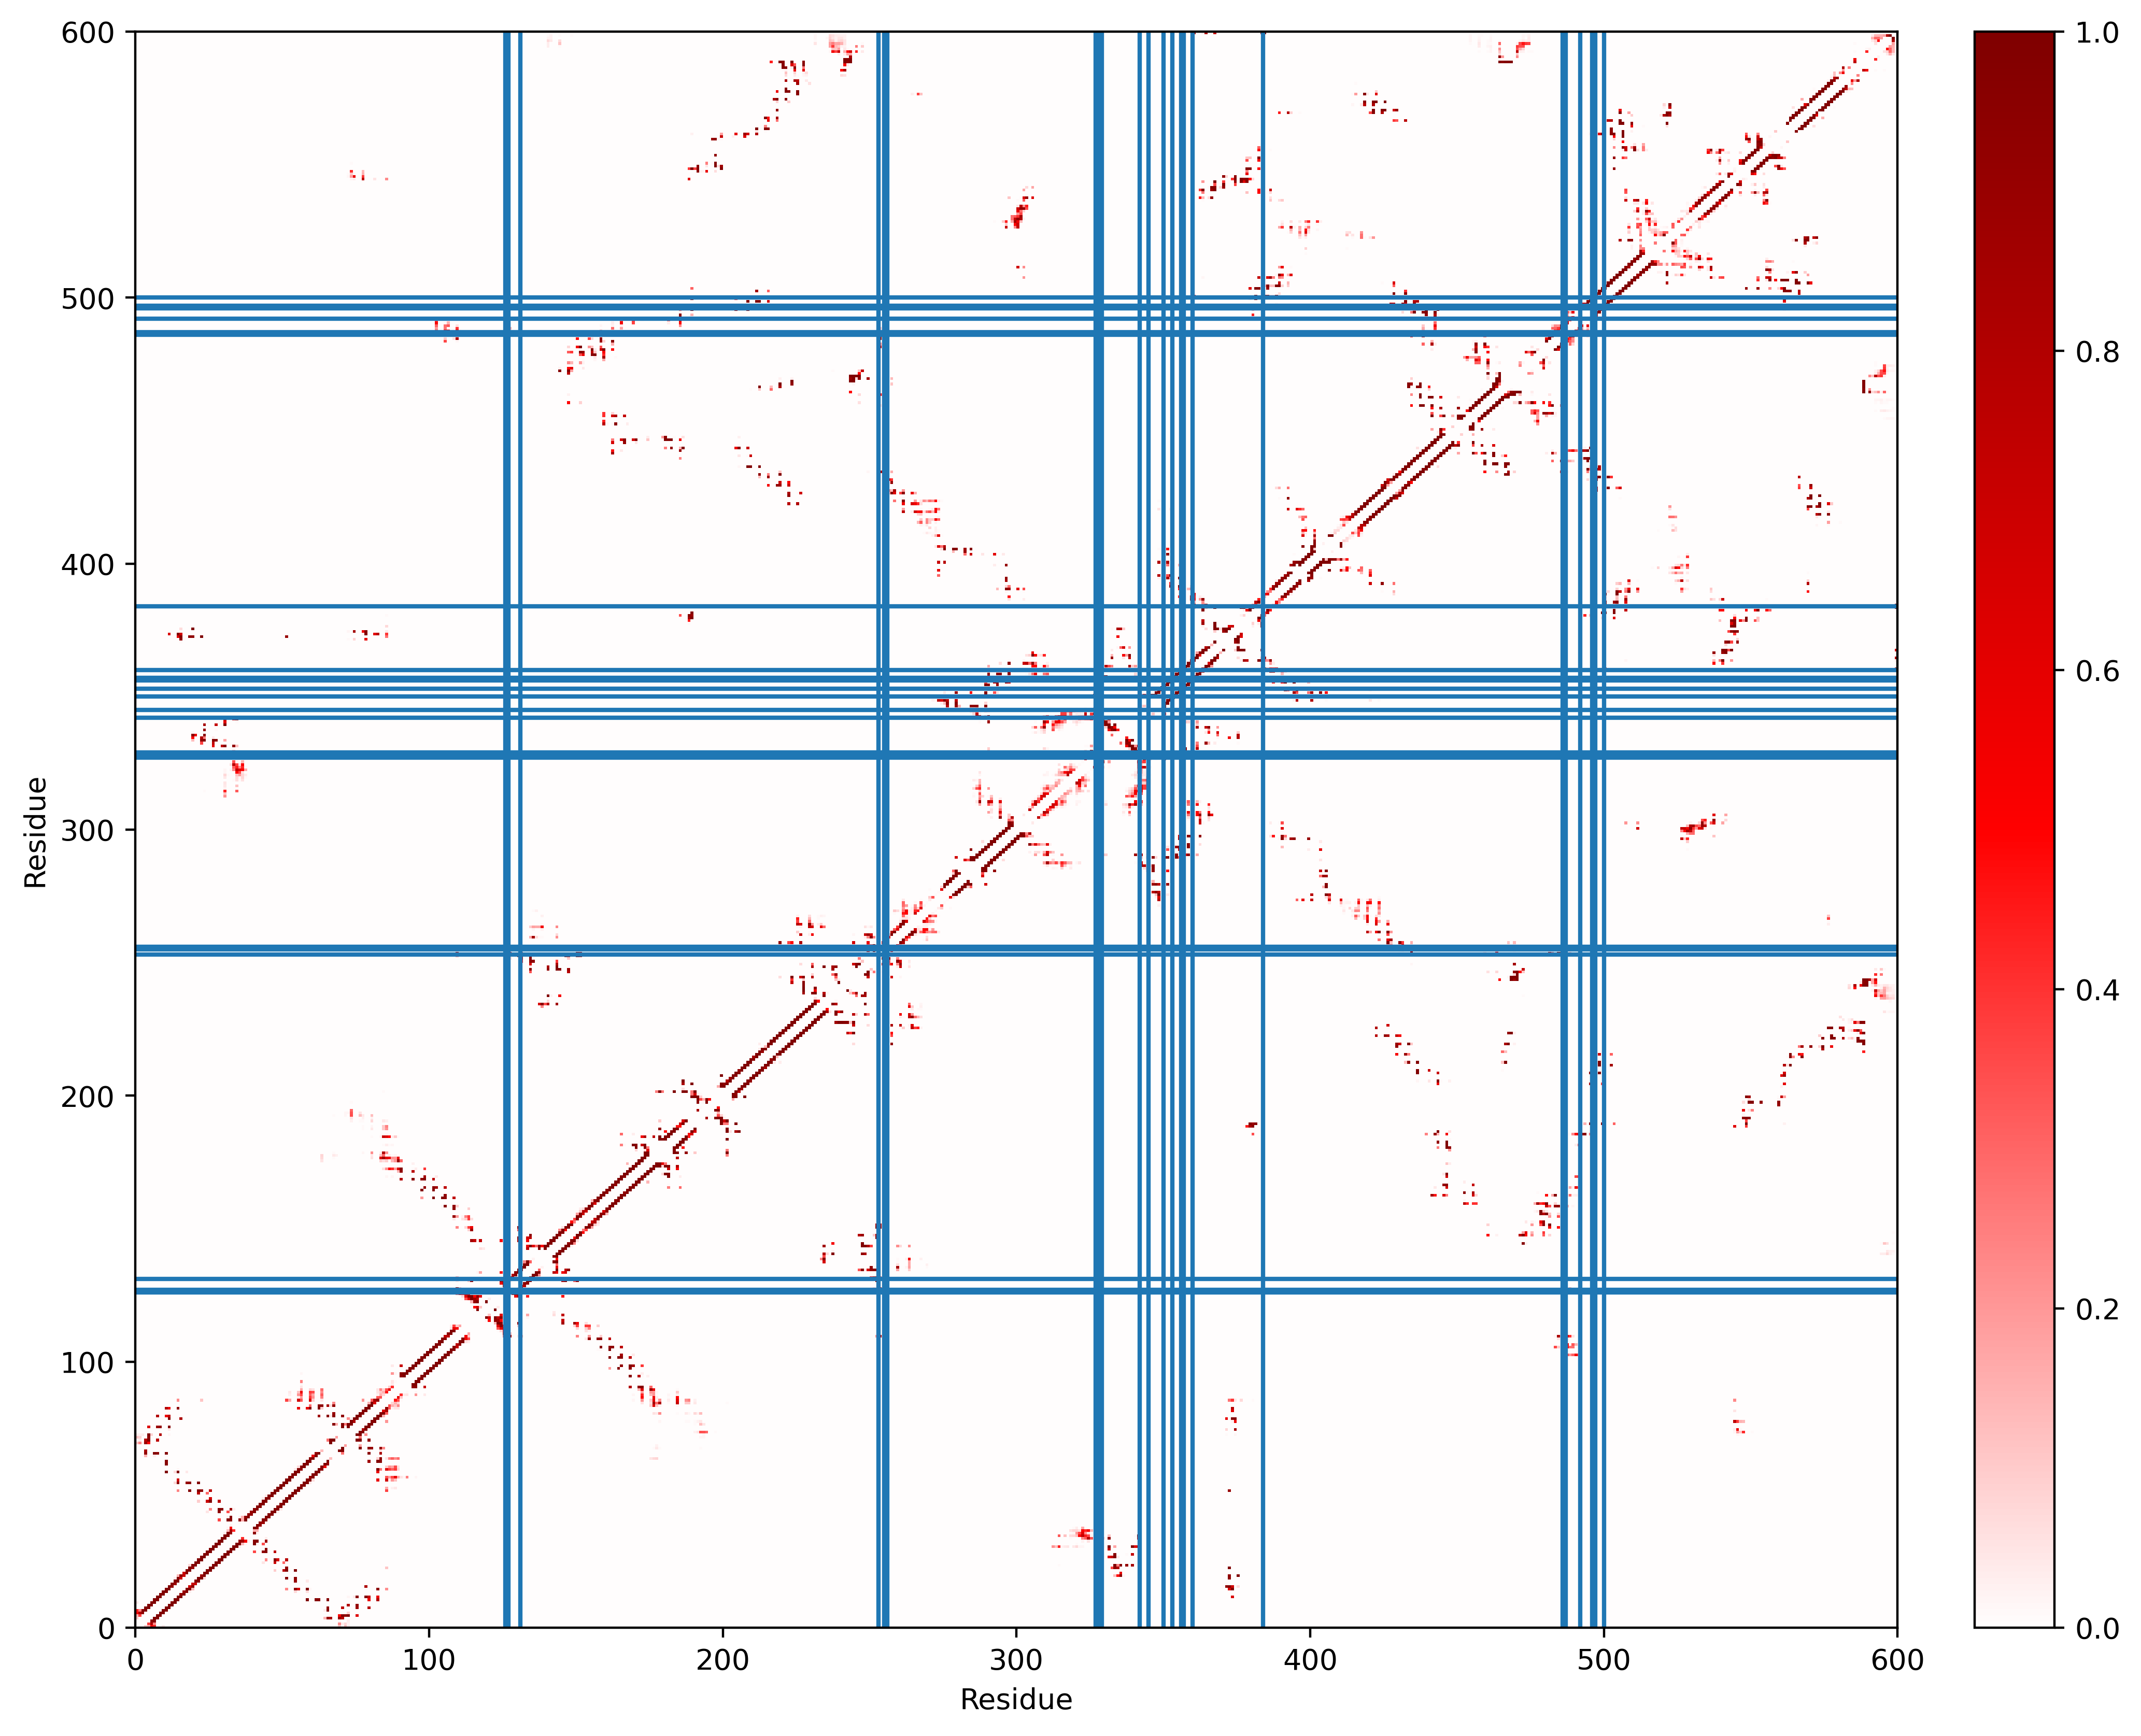

In [51]:
# look at apo contact map and mark ligand lining residues
fig, ax = apo_contacts.residue_contacts.plot(
    cmap='seismic', vmin=-1, vmax=1,dpi=400,figsize=(12,10));

plt.xlabel('Residue')
plt.ylabel('Residue')

plt.hlines(y=lining_inds[1],xmin=0,xmax=600)
plt.vlines(x=lining_inds[1],ymin=0,ymax=600)

In [ ]:
# contact map for holo trajectory
fig, ax = holo_contacts.residue_contacts.plot(
    cmap='seismic', vmin=-1, vmax=1,dpi=400,figsize=(12,10));

plt.xlabel('Residue')
plt.ylabel('Residue')


In [84]:
# compute change in contact frequencies 
contacts = diff.residue_contacts.sparse_matrix

126
127


In [98]:
# get contact frequencies for ligand lining residues
lin_contacts = np.zeros((23,23))
n1=0
for r1 in lining_inds[1]:
    n2=0
    for r2 in lining_inds[1]:
        lin_contacts[n1,n2] = contacts[(r1,r2)]
        n2+=1
    n1+=1

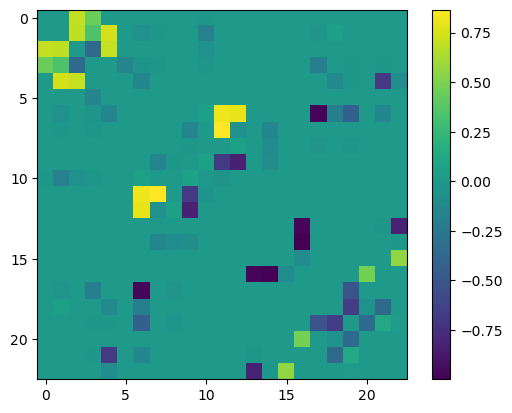

In [116]:
# viz change in contact frequencies in ligand lining residues
fig, ax = plt.subplots()
plt.imshow(lin_contacts)
plt.colorbar()

In [127]:
# print region of biggest neg change
print(str(lining_inds[1][13]) + " <-> " + str(lining_inds[1][16]))
print(str(lining_inds[1][14]) + " <-> " + str(lining_inds[1][16]))
trjapo.top.select
print(str(trjapo.top.residue(356)) + " <-> " + str(trjapo.top.residue(384)))
print(str(trjapo.top.residue(357)) + " <-> " + str(trjapo.top.residue(384)))


356 <-> 384
357 <-> 384
HIS374 <-> GLU402
GLU375 <-> GLU402


In [129]:
# print region of biggest pos change
print(str(lining_inds[1][6]) + " <-> " + str(lining_inds[1][11]))
print(str(lining_inds[1][6]) + " <-> " + str(lining_inds[1][12]))
print(str(lining_inds[1][7]) + " <-> " + str(lining_inds[1][11]))


print(str(trjapo.top.residue(327)) + " <-> " + str(trjapo.top.residue(350)))
print(str(trjapo.top.residue(327)) + " <-> " + str(trjapo.top.residue(353)))
print(str(trjapo.top.residue(328)) + " <-> " + str(trjapo.top.residue(350)))


327 <-> 350
327 <-> 353
328 <-> 350
HIS345 <-> ASP368
HIS345 <-> THR371
PRO346 <-> ASP368


CPU times: user 7.53 s, sys: 1.3 s, total: 8.83 s
Wall time: 10.5 s


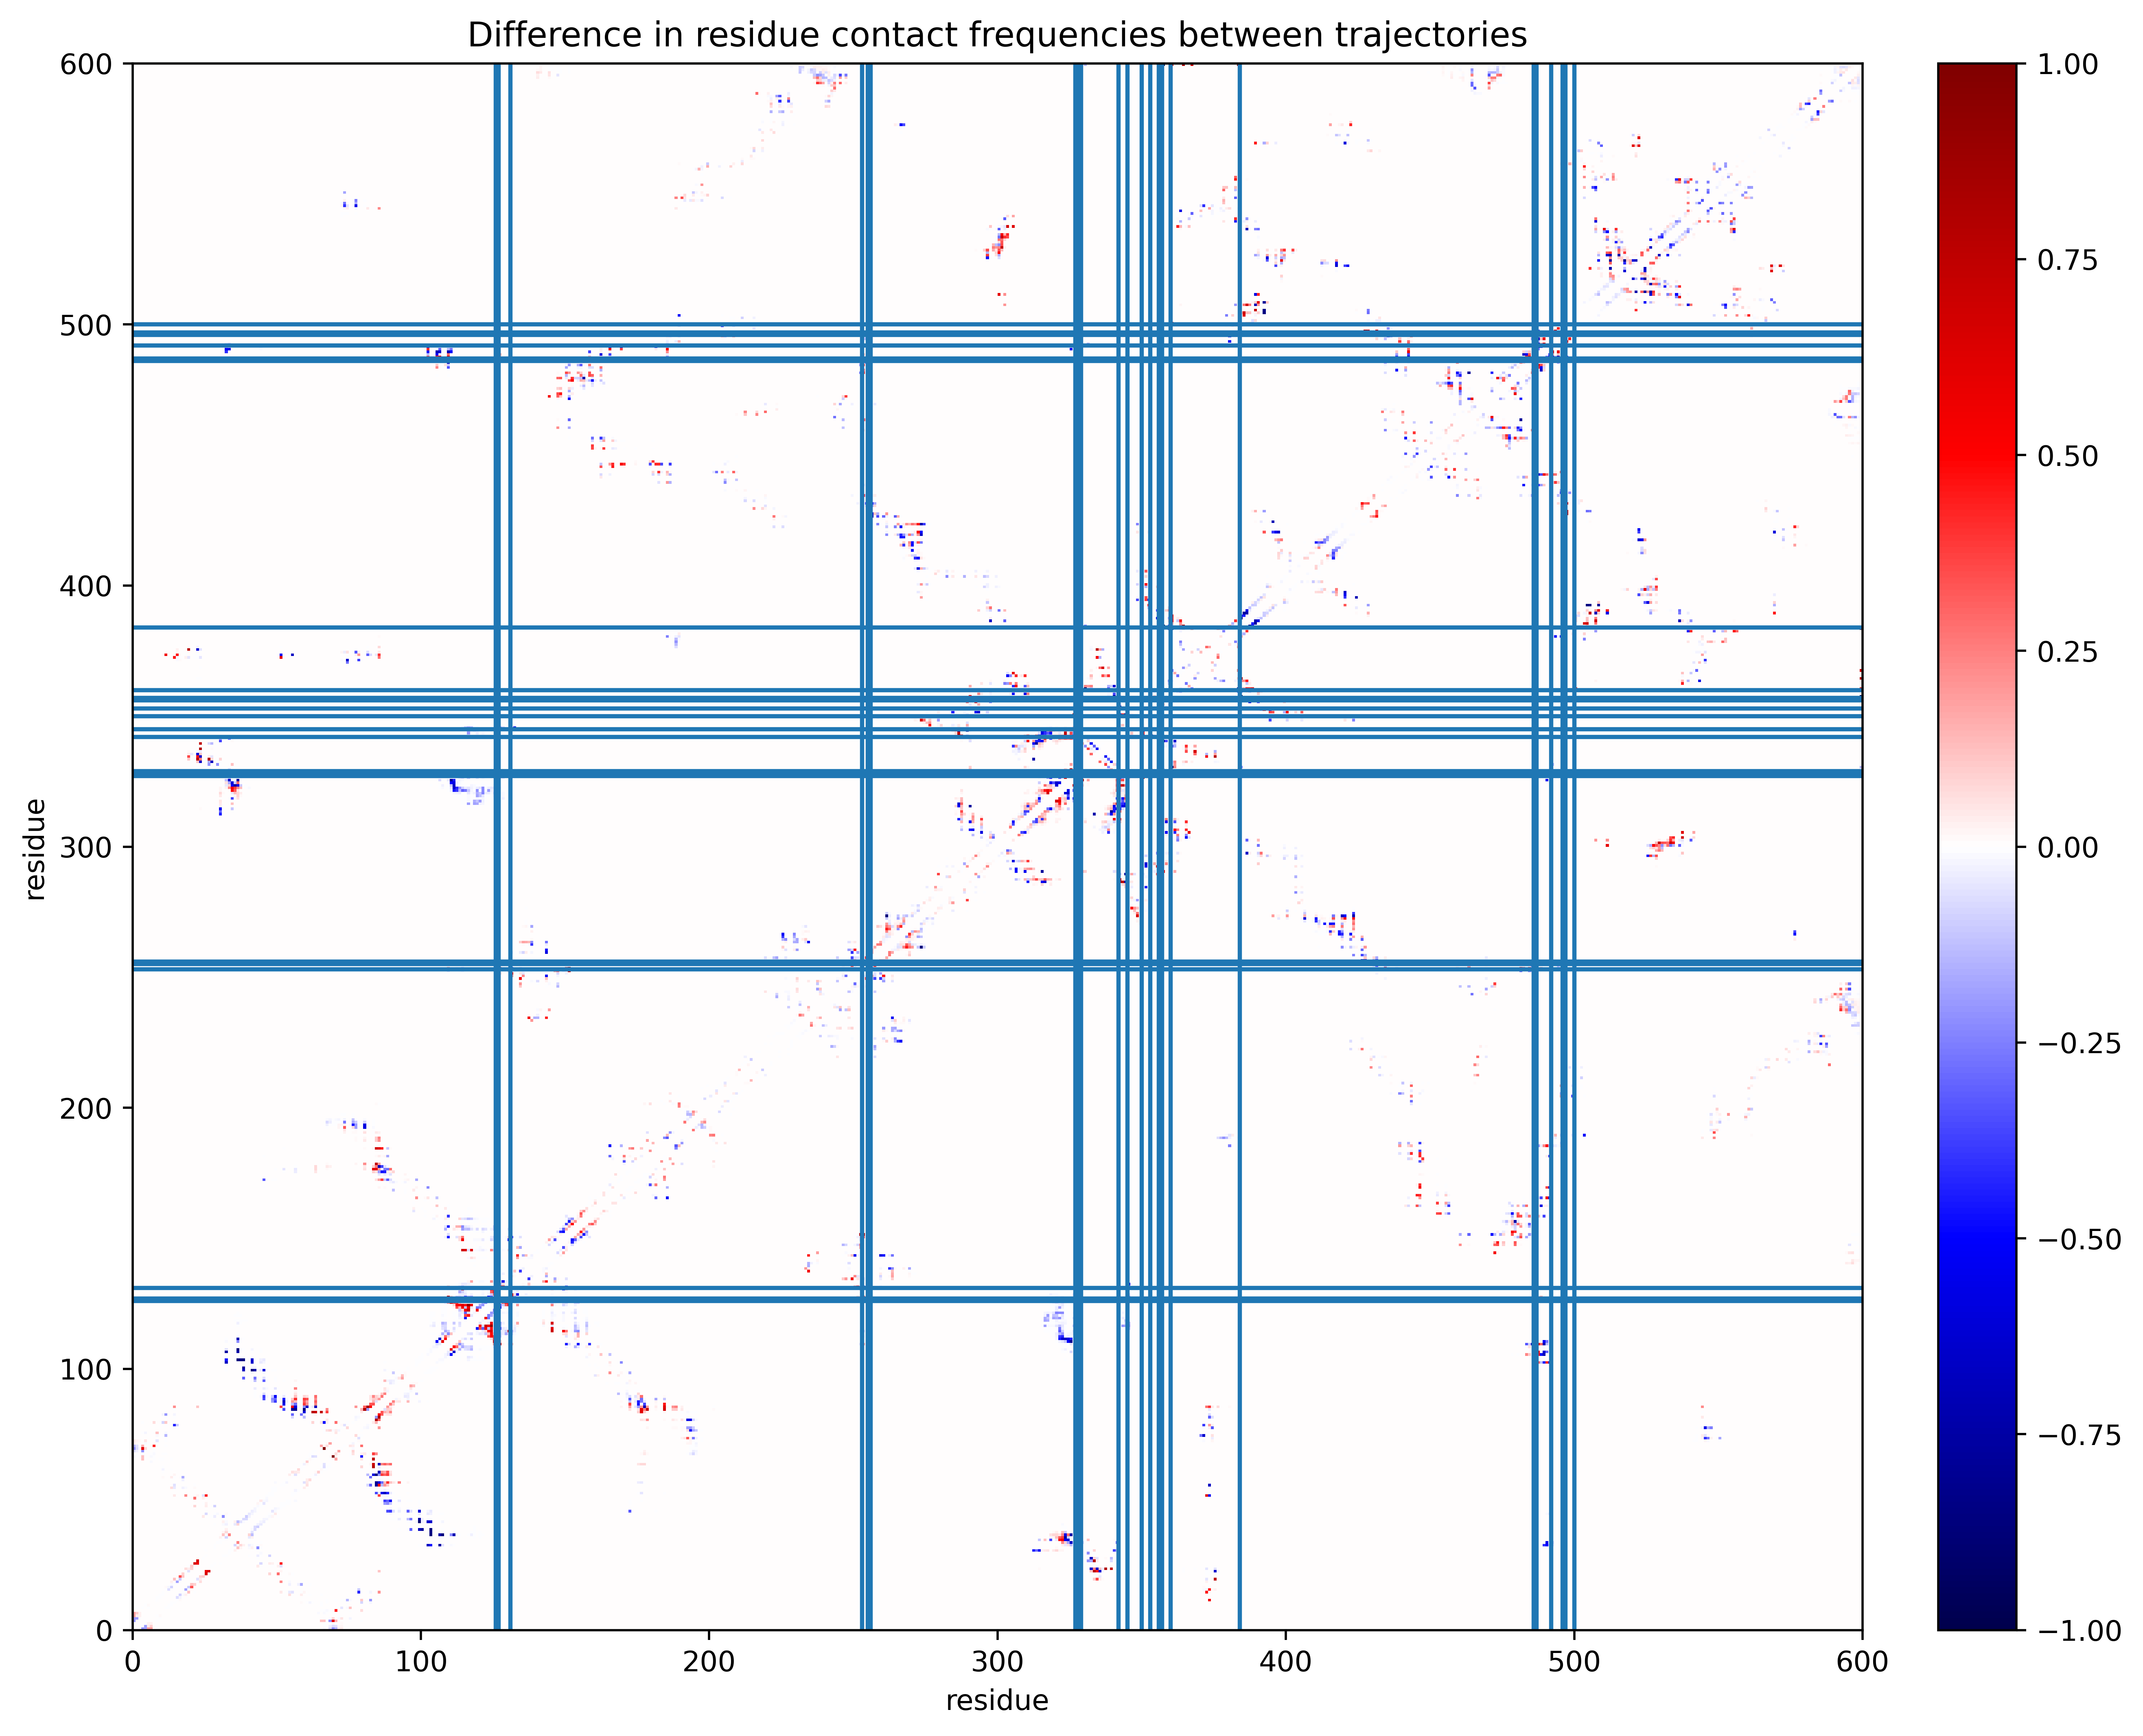

In [140]:
# viz changes in contact frequency and mark ligand lining residues
%%time
diff.residue_contacts.plot(cmap='seismic', vmin=-1, vmax=1,dpi=500,figsize=(12,10))
plt.xlabel('residue')
plt.ylabel('residue')
plt.title('Difference in residue contact frequencies between trajectories')
plt.hlines(y=lining_inds[1],xmin=0,xmax=600)
plt.vlines(x=lining_inds[1],ymin=0,ymax=600)